<a href="https://colab.research.google.com/github/nurdankar/GenerativeModels/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDream Gerçekleştirmesi

## Kimlik Doğrulama ve Dosya/Klasör Kontrolleri

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFIIKLvs-W_TfSDay7xSDneLNf-HOc7nsQpaKb4S8wvcqSFrw5nzXs
Mounted at /gdrive
/gdrive


In [ ]:
import os
os.chdir('/gdrive/My Drive/Calısma_Ortamı/Üretici Modeller(Generative Models)/')
!ls

DeepDream.ipynb  images


In [ ]:
import os
os.chdir('/gdrive/My Drive/Calısma_Ortamı/Üretici Modeller(Generative Models)/images/')
!ls

bw.jpg	sunset.jpg


## Gerekli Kütüphanelerin Yüklenmesi

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

## DeepDream Yapılandırması

In [ ]:
layer_settings = {
    "mixed4": 0.2,
    "mixed5": 3.,
    "mixed6": 2.,
    "mixed7": 1.5,}
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1034 (Conv2D)            (None, None, None, 3 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1034 (Batch (None, None, None, 3 96          conv2d_1034[0][0]                
__________________________________________________________________________________________________
activation_1034 (Activation)    (None, None, None, 3 0           batch_normalization_1034[0][0]   
_______________________________________________________________________________________

## Kullanmak İstediğimiz Görselin Yüklenmesi/Görüntülenmesi

In [ ]:
base_image_path = "bw.jpg"
result_prefix = "new_dream"

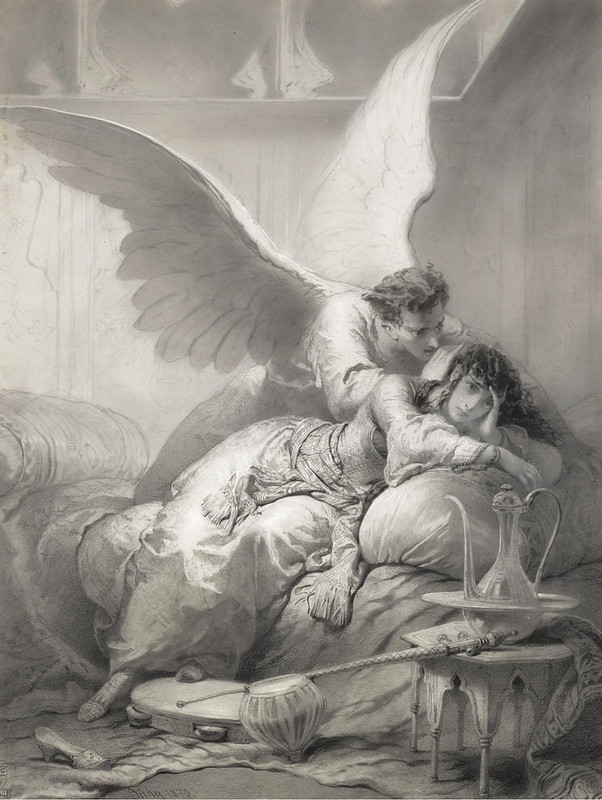

In [ ]:
from IPython.display import Image, display
display(Image(base_image_path))

## Yardımcı Fonksiyonlar

In [ ]:
# Resmi okuyan, yeniden boyutlandıran ve Inception V3 tarafından kullanılabilecek tensör formatına dönüştüren fonksiyon
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

# Tensörleri tekrar geçerli bir resime dönüştüren fonksiyon
def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.0
    x += 0.5
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)    # Öneğitimli bir InceptionV3 modelinin kullanılması
outputs_dict = dict([                                                      # Katman isimlerinin katmanlara eşlenmesi
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

## Enbüyütülecek Kayıp Fonksiyonunun Tanımlanması

In [ ]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32")) # Bir katmanın niteliklerine ait olan L2 normunun kayıp skoruna eklenmesi
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling #Kenar etkisini engellemek için kenardaki noktaların göz ardı edilmesi
    return loss

In [ ]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)                                       # Gradyanların hesaplanması
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)               # Gradyanın normalize edilmesi
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):                                            # Gradyan çıkışı döngüsü
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

## Gradyan Çıkışının Yapılandırılması

In [ ]:
step = 0.01            # Gradyan çıkışı adım büyüklüğü
num_octave = 3         # Gradyan çıkışının çalışacağı ölçekler
octave_scale = 1.3     # Ölçekler arasındaki mesafe
iterations = 20        # Her gradyan çıkış adımının kaç defa çalışacağı
max_loss = 15.0        # Kaybın 15'ten büyük olması durumunda gradyan çıkışının durdurulması

## Gradyan Çıkışının Çalıştırılması

In [ ]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (473, 356)
... Loss value at step 0: 0.67
... Loss value at step 1: 0.97
... Loss value at step 2: 1.34
... Loss value at step 3: 1.69
... Loss value at step 4: 2.00
... Loss value at step 5: 2.29
... Loss value at step 6: 2.58
... Loss value at step 7: 2.86
... Loss value at step 8: 3.12
... Loss value at step 9: 3.46
... Loss value at step 10: 3.70
... Loss value at step 11: 3.96
... Loss value at step 12: 4.29
... Loss value at step 13: 4.58
... Loss value at step 14: 4.88
... Loss value at step 15: 5.11
... Loss value at step 16: 5.39
... Loss value at step 17: 5.70
... Loss value at step 18: 5.95
... Loss value at step 19: 6.17
Processing octave 1 with shape (615, 463)
... Loss value at step 0: 1.57
... Loss value at step 1: 2.49
... Loss value at step 2: 3.08
... Loss value at step 3: 3.52
... Loss value at step 4: 4.01
... Loss value at step 5: 4.41
... Loss value at step 6: 4.86
... Loss value at step 7: 5.20
... Loss value at step 8: 5.54
... Los

## Sonucu Görselleştirme

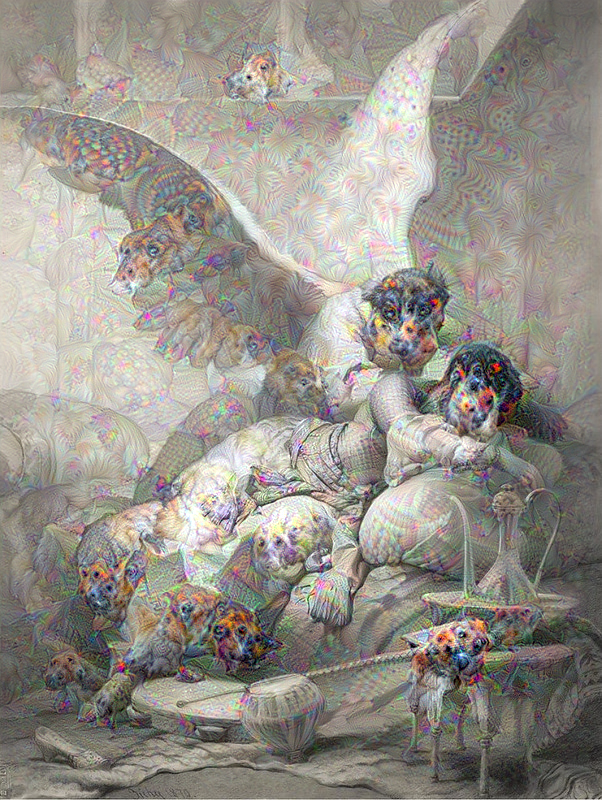

In [ ]:
display(Image(result_prefix + ".png"))

# Referanslar

1. François Chollet, Python ile Derin Öğrenme, 298-305, 2019
2. Merve Ayyüce Kızrak, Keras_ile_Derin_Ogrenmeye_Giris, GitHub

